# Lesson 6: Multimodal RAG with Multimodal Langchain

## Setup

In [1]:
import lancedb
from utils import load_json_file
from mm_rag.embeddings.bridgetower_embeddings import (
    BridgeTowerEmbeddings
)
from mm_rag.vectorstores.multimodal_lancedb import MultimodalLanceDB
from mm_rag.MLM.client import PredictionGuardClient
from mm_rag.MLM.lvlm import LVLM
from PIL import Image
from langchain_core.runnables import (
    RunnableParallel, 
    RunnablePassthrough, 
    RunnableLambda
)

### Preprocessing

#### Setup LanceDB vectorstore

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
We'll use the Youtube video 
<br>
<a href="https://www.youtube.com/watch?v=7Hcg-rLYwdM">
https://www.youtube.com/watch?v=7Hcg-rLYwdM</a> 
<br>
preprocessed in Lesson 3 and ingested to LanceDB in Lesson 4.
<br>
If you haven't created vectorstore `test_tbl` in Lesson 4, 
<br>
please update <code>TBL_NAME="demo_tbl"</code> to use the pre-populated data.
</p>

In [2]:
# declare host file
LANCEDB_HOST_FILE = "./shared_data/.lancedb"

# declare table name
TBL_NAME = "test_tbl"

# if you haven't practice Lesson 3 and 4, 
#   change 'test_tbl' to 'demo_tbl' to use pre-populated data
#   by uncomment the following line
#TBL_NAME = "demo_tbl"

### Retrieval Module
#### Initialize Embedding Model

In [3]:
# initialize an BridgeTower embedder 
embedder = BridgeTowerEmbeddings()

#### Create Retrieval

In [4]:
## Creating a LanceDB vector store 
vectorstore = MultimodalLanceDB(
    uri=LANCEDB_HOST_FILE, 
    embedding=embedder, 
    table_name=TBL_NAME
)

### creating a retriever for the vector store
### with search_type="similarity" and search_kwargs={"k": 1} 
retriever_module = vectorstore.as_retriever(
    search_type='similarity', 
    search_kwargs={"k": 1}
)

#### Invoke Retrieval with User Query

In [5]:
# Invoke the retrieval for a query
query = "What do the astronauts feel about their work?"
retrieved_video_segments = retriever_module.invoke(query)
# get the first retrieved video segment
retrieved_video_segment = retrieved_video_segments[0]

Transcript:
As I look back on the the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months.

Path to extracted frame: ./shared_data/videos/video1/extracted_frame/frame_1.jpg
Path to video: ./shared_data/videos/video1/Welcome back to Planet Earth.mp4
Timestamp in ms when the frame was extracted: 8719.0


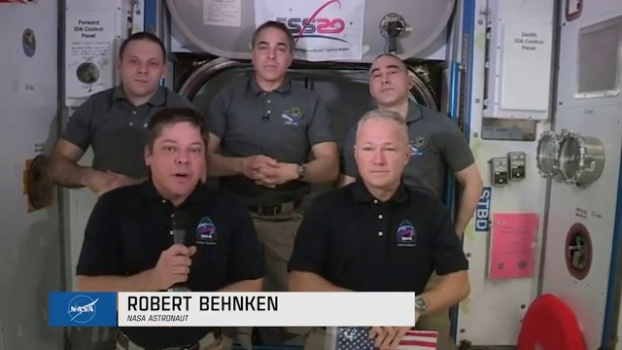

In [6]:
# get all metadata of the retrieved video segment
retrieved_metadata = retrieved_video_segment.metadata['metadata']

# get the extracted frame
frame_path = retrieved_metadata['extracted_frame_path']
# get the corresponding transcript
transcript = retrieved_metadata['transcript']
# get the path to video where the frame was extracted
video_path = retrieved_metadata['video_path']
# get the time stamp when the frame was extracted
timestamp = retrieved_metadata['mid_time_ms']

# display
print(f"Transcript:\n{transcript}\n")
print(f"Path to extracted frame: {frame_path}")
print(f"Path to video: {video_path}")
print(f"Timestamp in ms when the frame was extracted: {timestamp}")
display(Image.open(frame_path))

### LVLM Inference Module

#### Initialize Client and LVLM for Inference

In [7]:
# initialize a client as PredictionGuardClient
client = PredictionGuardClient()
# initialize LVLM with the given client
lvlm_inference_module = LVLM(client=client)

#### Invoke LVLM Inference with User Query

In [8]:
# This new query is the augmentation of the previous query
# with the transcript retrieved above. 
augmented_query_template = (
    "The transcript associated with the image is '{transcript}'. "
    "{previous_query}"
)
augmented_query = augmented_query_template.format(
    transcript=transcript,
    previous_query=query,
)
print(f"Augmented query is:\n{augmented_query}")

Augmented query is:
The transcript associated with the image is 'As I look back on the the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months.'. What do the astronauts feel about their work?


In [9]:
# we use the augmented query and the retrieved path-to-image
# as the input to LVLM inference module
input = {'prompt':augmented_query, 'image': frame_path}
response = lvlm_inference_module.invoke(input)

# display the response
print('LVLM Response:')
print(response)

LVLM Response:
The astronauts in the image appear to be proud of their work on the International Space Station. They are all wearing shirts and ties, which suggests a professional and formal atmosphere. One of the astronauts is holding a microphone, indicating that they might be discussing their experiences or sharing information with the public. The fact that they are all smiling and posing for a picture together suggests that they are comfortable with each other and are likely enjoying their time on the space station.


### Prompt Processing Module

In [10]:
def prompt_processing(input):
    # get the retrieved results and user's query
    retrieved_results = input['retrieved_results']
    user_query = input['user_query']
    
    # get the first retrieved result by default
    retrieved_result = retrieved_results[0]
    prompt_template = (
      "The transcript associated with the image is '{transcript}'. "
      "{user_query}"
    )
    
    # get all metadata of the retrieved video segment
    retrieved_metadata = retrieved_result.metadata['metadata']

    # get the corresponding transcript
    transcript = retrieved_metadata['transcript']
    # get the extracted frame
    frame_path = retrieved_metadata['extracted_frame_path']
    
    return {
        'prompt': prompt_template.format(
            transcript=transcript, 
            user_query=user_query
        ),
        'image' : frame_path
    }
    
# initialize prompt processing module 
# as a Langchain RunnableLambda of function prompt_processing
prompt_processing_module = RunnableLambda(prompt_processing)

#### Invoke Prompt Processing Module with Retrieved Results and User Query

In [11]:
# We use the user query and the retrieved results above
input_to_lvlm = prompt_processing_module.invoke(
    {
        'retrieved_results': retrieved_video_segments, 
        'user_query': query
    })

# display output of prompt processing module 
#  which is the input to LVLM Inference module
print(input_to_lvlm)

{'prompt': "The transcript associated with the image is 'As I look back on the the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months.'. What do the astronauts feel about their work?", 'image': './shared_data/videos/video1/extracted_frame/frame_1.jpg'}


### Multimodal RAG

#### Define Multimodal RAG System as a Chain in LangChain

We are going to make use of the followings from `Langchain`:
- The `RunnableParallel` primitive is essentially a dict whose values are runnables (or things that can be coerced to runnables, like functions). It runs all of its values in parallel, and each value is called with the overall input of the RunnableParallel. The final return value is a dict with the results of each value under its appropriate key.
- The `RunnablePassthrough` on its own allows you to pass inputs unchanged. This typically is used in conjuction with RunnableParallel to pass data through to a new key in the map.
- The `RunnableLambda` converts a python function into a Runnable. 
Wrapping a function in a RunnableLambda makes the function usable within either a sync or async context.

In [12]:
# combine all the modules into a chain 
# to create Multimodal RAG system
mm_rag_chain = (
    RunnableParallel({
        "retrieved_results": retriever_module , 
        "user_query": RunnablePassthrough()
    }) 
    | prompt_processing_module
    | lvlm_inference_module
)

#### Invoke the Multimodal RAG System with a Query

In [13]:
# invoke the Multimodal RAG system with a query
query1 = "What do the astronauts feel about their work?"
final_text_response1 = mm_rag_chain.invoke(query1)
# display
print(f"USER Query: {query1}")
print(f"MM-RAG Response: {final_text_response1}")

USER Query: What do the astronauts feel about their work?
MM-RAG Response: The astronauts in the image appear to be proud of their work on the International Space Station. They are all wearing shirts and ties, which suggests a professional and formal atmosphere. One of the astronauts is holding a microphone, indicating that they might be discussing their experiences or sharing information with the public. The fact that they are all smiling and posing for a picture together suggests that they are comfortable with each other and are likely enjoying their time on the space station.


In [14]:
# let's try another query
query2 = "What is the name of one of the astronauts?"
final_text_response2 = mm_rag_chain.invoke(query2)
# display
print(f"USER Query: {query2}")
print(f"MM-RAG Response: {final_text_response2}")

USER Query: What is the name of one of the astronauts?
MM-RAG Response: One of the astronauts is named Robert Behnken.


#### Multimodal RAG System Showing Retrieved Image/Frame


In [15]:
# the output of this new chain will be a dictionary
mm_rag_chain_with_retrieved_image = (
    RunnableParallel({
        "retrieved_results": retriever_module , 
        "user_query": RunnablePassthrough()
    }) 
    | prompt_processing_module
    | RunnableParallel({
        'final_text_output': lvlm_inference_module, 
        'input_to_lvlm' : RunnablePassthrough()
    })
)

In [16]:
# let's try again with query2
response3 = mm_rag_chain_with_retrieved_image.invoke(query2)
# display
print("Type of output of mm_rag_chain_with_retrieved_image is:")
print(type(response3))
print(f"Keys of the dict are {response3.keys()}")

Type of output of mm_rag_chain_with_retrieved_image is:
<class 'dict'>
Keys of the dict are dict_keys(['final_text_output', 'input_to_lvlm'])


USER Query: What is the name of one of the astronauts?
MM-RAG Response: One of the astronauts is named Robert Behnken.
Retrieved frame:


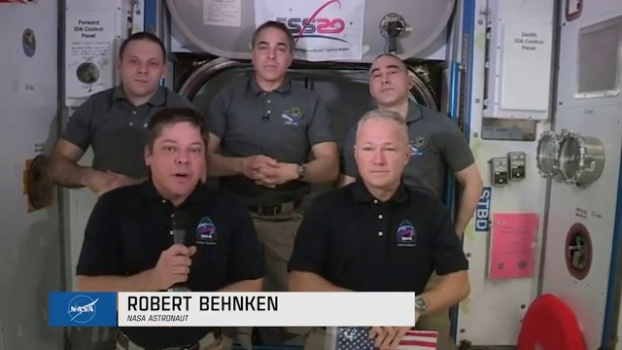

In [17]:
# We now extract final text response and path to extracted frame
final_text_response3 = response3['final_text_output']
path_to_extracted_frame = response3['input_to_lvlm']['image']

# display
print(f"USER Query: {query2}")
print(f"MM-RAG Response: {final_text_response3}")
print("Retrieved frame:")
display(Image.open(path_to_extracted_frame))

USER Query: an astronaut's spacewalk

MM-RAG Response: 

The image shows an astronaut wearing a white space suit, standing on a spacecraft and performing a spacewalk. The astronaut is holding onto a metal bar, which is likely a part of the spacecraft's structure. The scene captures the excitement and challenges of space exploration, as the astronaut carries out a critical task in the mission. The image also highlights the astronaut's skill and expertise in handling the dangers and complexities of working in the harsh environment of space.

Retrieved frame:


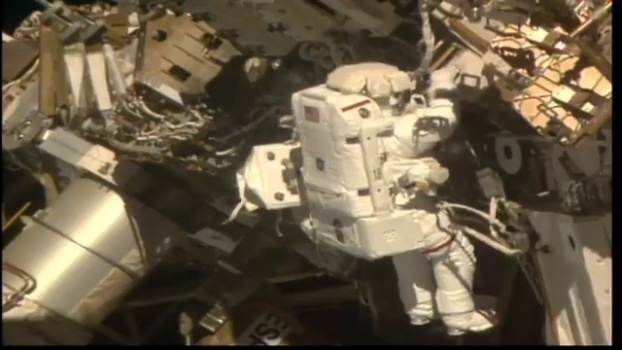

In [18]:
# let's try again with another query
query4 = "an astronaut's spacewalk"
response4 = mm_rag_chain_with_retrieved_image.invoke(query4)
# extract results
final_text_response4 = response4['final_text_output']
path_to_extracted_frame4 = response4['input_to_lvlm']['image']
# display
print(f"USER Query: {query4}")
print()
print(f"MM-RAG Response: {final_text_response4}")
print()
print("Retrieved frame:")
display(Image.open(path_to_extracted_frame4))

USER Query: Describe the image of an astronaut's spacewalk with an amazing view of the earth from space behind

MM-RAG Response: The image captures an astronaut in a white space suit, performing a spacewalk outside the International Space Station (ISS). The astronaut is standing on a metal structure, possibly a part of the ISS, and appears to be working on a task or conducting maintenance. The view from space is breathtaking, showcasing the Earth below, with its vibrant colors and intricate patterns. The scene evokes a sense of awe and accomplishment, as the astronaut takes part in this extraordinary mission.

Retrieved Frame:


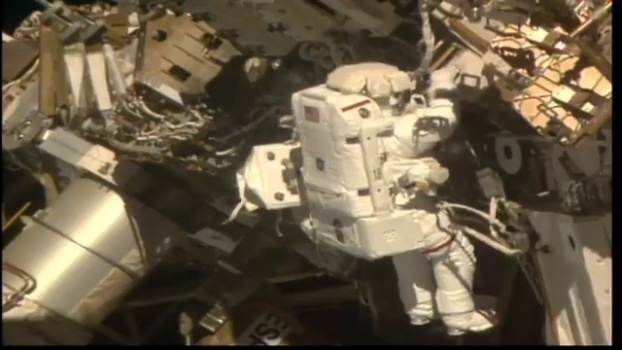

In [19]:
# We would like an astronaut's spacewalk with the earth view behind
query5 = (
    "Describe the image of an astronaut's spacewalk "
    "with an amazing view of the earth from space behind"
)
response5 = mm_rag_chain_with_retrieved_image.invoke(query5)
# extract results
final_text_response5 = response5['final_text_output']
path_to_extracted_frame5 = response5['input_to_lvlm']['image']
# display
print(f"USER Query: {query5}")
print()
print(f"MM-RAG Response: {final_text_response5}")
print()
print("Retrieved Frame:")
display(Image.open(path_to_extracted_frame5))

In [ ]:
# Slightly change the query5
query6 = (
    "An astronaut's spacewalk with "
    "an amazing view of the earth from space behind"
)
response6 = mm_rag_chain_with_retrieved_image.invoke(query6)
# extract results
final_text_response6 = response6['final_text_output']
path_to_extracted_frame6 = response6['input_to_lvlm']['image']
# display
print(f"USER Query: {query6}")
print()
print(f"MM-RAG Response: {final_text_response6}")
print()
print("Retrieved Frame:")
display(Image.open(path_to_extracted_frame6))

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b> 
Slightly changing the query may lead to different retrieved results 
and thus different final response.
</p>

***

#### To access latest Intel&reg; Gaudi&reg; 3 AI Accelerator and large-scale AI clusters please visit [cloud.intel.com](https://cloud.intel.com)

![Intel Tiber Developer Cloud](../assets/ITDC.png)